# LabelUp API
This notebook will go over how to use the LabelUp API for automated labeling of your images. LabelUp comprises two models working together to take users from providing a few key points on select images to automatically labeling a whole corpus through in-context prompting. The first model is the Segment Anything Model (SAM) and the second is the SegGPT model.

In [1]:
# If working directly with the code youll need to run this relative import
import sys
sys.path.append("..")


In [2]:
#Imports
from labelup.sam import SAMInference
from labelup.utils import write_boolean_mask, plot_img, plot_mask
import random
import os

In [3]:
#If you have multiple GPUs you can set the specific GPU to use here - otherwise you can ignore

GPU_NUMBER= '3'
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_NUMBER

# Segment Anything Model (SAM)
This model helps users label an object just by selecting a keypoint. Ideally this functionality would be exposed through a full featured UI, but since we only need to annotate a couple images, manually secting the x,y coordinates of the point is not too burdonsome.

In [4]:
# Instantiate our SAM model 

MODEL_PATH = None
# if you would like the model to download to a specific path uncomment below
# first download may take several minutes
#MODEL_PATH= "/data/models/"
sam = SAMInference(MODEL_PATH)

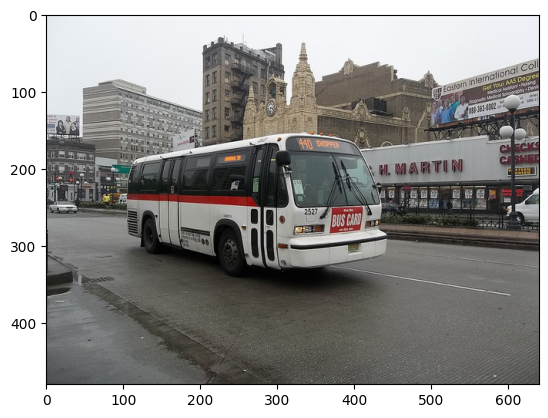

In [5]:
# select an image to label

imgpath = "../samples/testbuses/unlabelled/000000099844.jpg"
plot_img(imgpath)

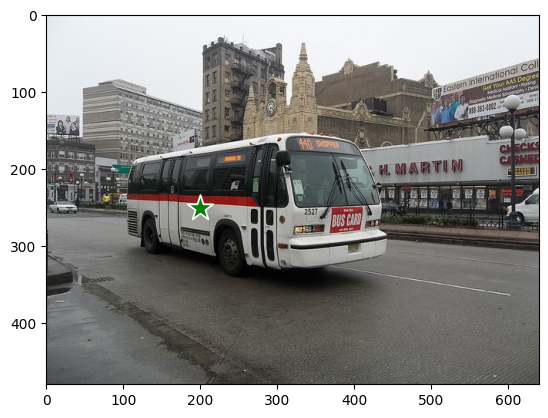

In [6]:
# Select a key point for the SAM model 
x= 200
y=250
plot_img(imgpath, point= (x,y))

In [7]:
#Expand key point to a segmentation mask
masks = sam.predict((x,y), img_path=imgpath)



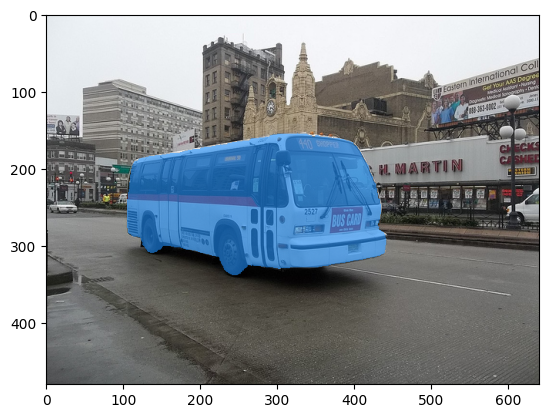

In [8]:
#plot mask


# there will be several masks returned - the first one will be the highest confidence
# you may need to render a few masks to find the best fitting one - here we see the best choice
# is mask number 3
mask = masks[2]
plot_mask(imgpath, mask)

In [9]:
# Store mask results - 
# The current version of LabelUp uses image files as it transitions between models
# So here we will store the mask in a temporary file
tmpdir = "tmp"
if not os.path.exists(tmpdir):
    os.makedirs(tmpdir)

#write file
bus_mask_path = os.path.join(tmpdir, "sample_bus_mask.jpg")

write_boolean_mask(bus_mask_path, mask)

# SegGPT Model

The SegGPT model will take our mask we just created and use this context to label a corpus of images

In [10]:
#imports 
from labelup.seggpt import SegGPTInference
from labelup.utils import get_files, mask_to_bbox,plot_image_and_bboxes


/home/jdownes/labelup-core/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
#instantiate our SegGPT model

MODEL_PATH = None
# if you would like the model to download to a specific path uncomment below
# first download may take several minutes
#MODEL_PATH= "/data/models/"
seg_gpt = SegGPTInference(MODEL_PATH)

<Figure size 1500x1500 with 0 Axes>

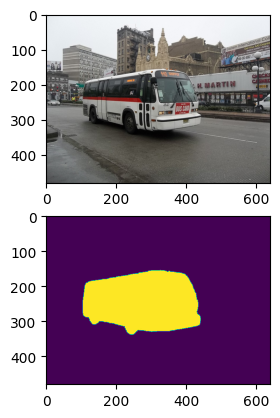

In [13]:
# we can take a look at input images and masks here
# we only have 1 image and mask example but the SegGPT can leverage multiple examples at runtime
# this method will render a list of images and masks
from labelup.utils import plot_images_and_masks

prompt_image_paths = [imgpath] # you could add more images here
prompt_mask_paths = [bus_mask_path] # you could add more masks here
plot_images_and_masks(prompt_image_paths, prompt_mask_paths)

../samples/testbuses/unlabelled/000000084183.jpg


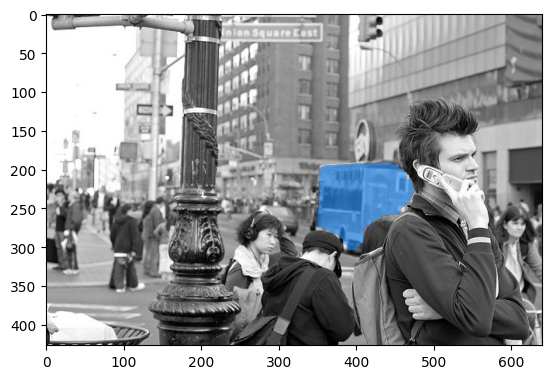

../samples/testbuses/unlabelled/000000096351.jpg


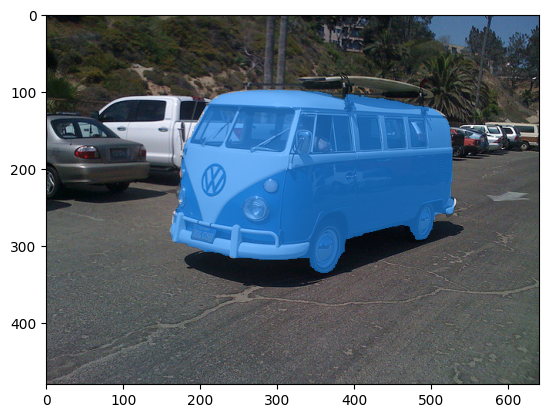

../samples/testbuses/unlabelled/000000067749.jpg


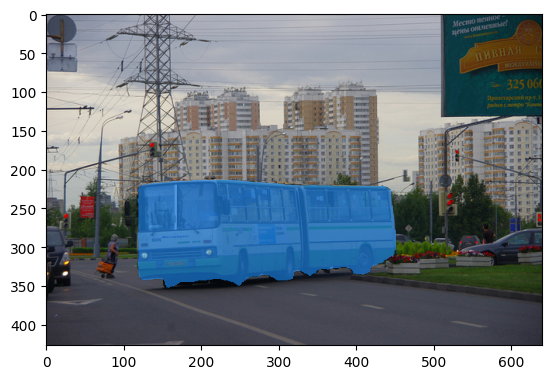

../samples/testbuses/unlabelled/000000008834.jpg


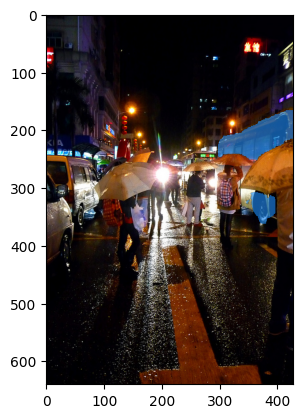

../samples/testbuses/unlabelled/000000030508.jpg


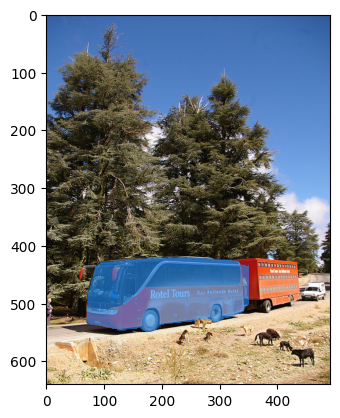

In [14]:
# Lets run some autolabeling useing SegGPT on new images,
# with our input image and mask as context

unlabeled_dataset_path="../samples/testbuses/unlabelled/"
unlabeled_images = get_files(unlabeled_dataset_path, ".jpg")
n_samples = 5

for sample in random.choices(unlabeled_images, k=n_samples):
    print(sample)
    mask = seg_gpt.run_inference_image(sample, 
                                        prompt_image_paths, 
                                        prompt_mask_paths
    )
    plot_mask(sample, mask)


../samples/testbuses/unlabelled/000000099888.jpg


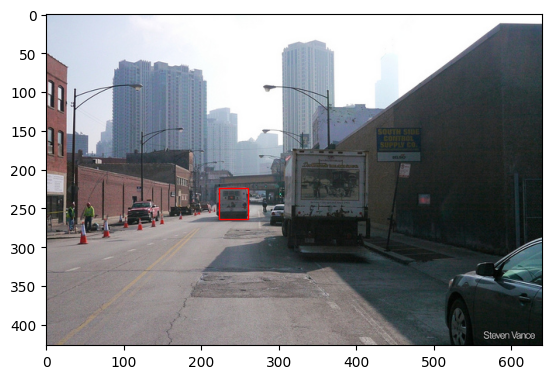

../samples/testbuses/unlabelled/000000063556.jpg


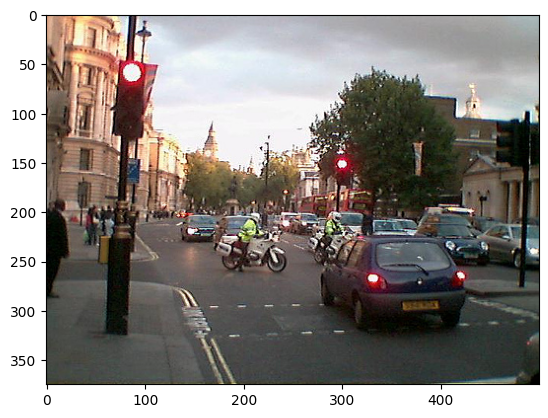

../samples/testbuses/unlabelled/000000099888.jpg


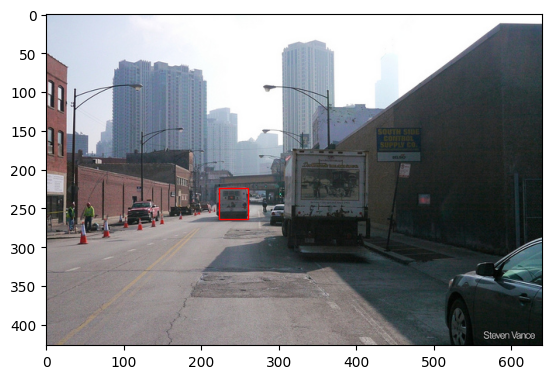

../samples/testbuses/unlabelled/000000044801.jpg


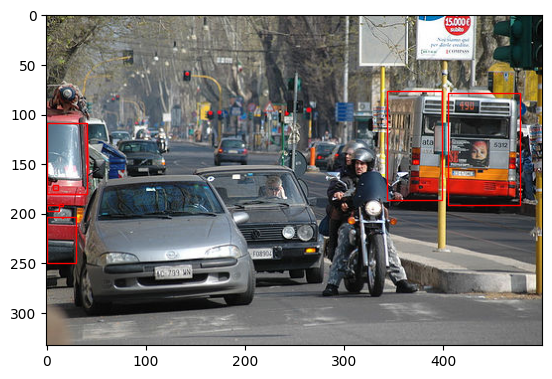

../samples/testbuses/unlabelled/000000072740.jpg


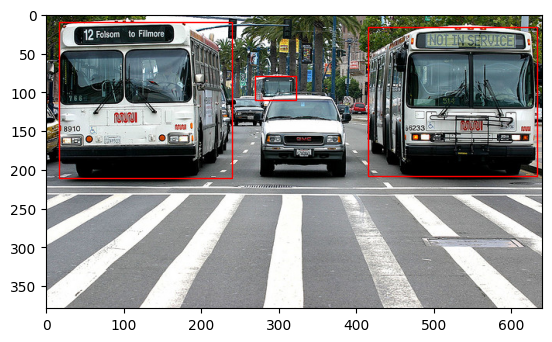

In [15]:
# If working with bboxes is simpler there is a helper method to convert

for sample in random.choices(unlabeled_images, k=n_samples):
    print(sample)
    mask = seg_gpt.run_inference_image(sample, 
                                        prompt_image_paths, 
                                        prompt_mask_paths
    )
    #convert mask to bboxes
    bboxes = mask_to_bbox(mask)
    plot_image_and_bboxes(sample, bboxes)

In [ ]:
# TODO evaluation utils - use the sample buse masks